In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from transformers import Dinov2Model

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir     = '/Users/k.choi/Documents/github/csiro_git'
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()

In [3]:
def preprocess_data(df, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
    unqiue_path = df['image_path'].unique()
    data_list = []
    for uni_path in unqiue_path:

        data = df[df['image_path'] == uni_path]
        row   = {'image_path': uni_path} 

        for tar in target_names: 
            row[tar] = data[data['target_name'] == tar]['target'].values[0]
            
        data_list.append(row)   

    return pd.DataFrame(data_list)

In [4]:
data = preprocess_data(csv_data)

train_data, valid_data = train_test_split(data, test_size=0.16, random_state=8964)
train_data, test_data  = train_test_split(train_data, test_size=0.04, random_state=8964)

print(f"train data: {len(train_data)}")
print(f"valid data: {len(valid_data)}")
print(f"test data: {len(test_data)}")


train data: 287
valid data: 58
test data: 12


In [5]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return image, targets


In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

batch_size = 16 
WORKERS = 0


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomRotation([-15,15]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_ds = BiomassDS(df =train_data, data_dir=data_dir, transform=train_transform)
valid_ds = BiomassDS(df =valid_data, data_dir=data_dir, transform=valid_transform)
test_ds  = BiomassDS(df =test_data, data_dir=data_dir, transform=valid_transform)

assert len(train_ds) == len(train_data) and len(valid_ds) == len(valid_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=True  , pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)

sample_img, sample_target = train_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = valid_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)
sample_img, sample_target = test_ds[0]
assert sample_img.shape == (3, 224, 224) and sample_target.shape == (5,)


In [7]:
class get_smalldino(nn.Module):

    def __init__(self, backbone, patch_dim = 384, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [8]:
class get_basedino(nn.Module):

    def __init__(self, backbone, patch_dim = 768, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [9]:
class get_largedino(nn.Module):

    def __init__(self, backbone, patch_dim = 1024, num_targets = 5):
        super().__init__()
        self.backbone = backbone  

        for params in self.backbone.parameters():
            params.requires_grad = False

        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, num_targets)
        )

    def forward(self, x):

        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        
        batch_size, num_patches, patch_dim = patch_features.shape 
        patch_features_flat = patch_features.reshape(-1, patch_dim) ### (batch_size * num_patches, 384)
        patch_preds = self.heads(patch_features_flat) ### (batch_size * num_patches, num_targets)
        patch_preds = patch_preds.reshape(batch_size, num_patches, -1)  ### (batch_size, num_patches, num_targets)

        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred, patch_preds


In [10]:
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small')
# dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-base')
dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-large')
dinov2_backbone.eval()
dinov2_backbone.to(device)

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,),

In [11]:
# model = get_smalldino(dinov2_backbone, patch_dim=384, num_targets=5)
# model = get_basedino(dinov2_backbone, patch_dim=768, num_targets=5)
model = get_largedino(dinov2_backbone, patch_dim=1024, num_targets=5)
model.to(device)

all_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {all_params}")
train_params = sum(p.numel() for p in model.heads.parameters())
print(f"Trainable parameters: {train_params}")
frozen_params = sum(p.numel() for p in model.backbone.parameters())
print(f"Frozen parameters: {frozen_params}")


Total parameters: 305027589
Trainable parameters: 658949
Frozen parameters: 304368640


In [12]:
LR = 3e-3 
WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5


optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
criterion = nn.MSELoss()

In [13]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    num_batches = 0

    pbar = tqdm(loader, desc='Training')

    for img, tar in pbar:
        img = img.to(device)
        tar = tar.to(device)

        optimizer.zero_grad()

        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    return avg_loss

def validate_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0
    num_batches = 0
    
    all_preds = []
    all_targs = []

    with torch.no_grad():

        pbar = tqdm(loader, desc='Validation')
        for img, tar in pbar:
            img = img.to(device)
            tar = tar.to(device)

            pred, _ = model(img)
            loss = criterion(pred, tar)

            total_loss += loss.item()
            num_batches += 1

            all_preds.append(pred.cpu())
            all_targs.append(tar.cpu())

    avg_loss  = total_loss / num_batches
    all_preds = torch.cat(all_preds).numpy()
    all_targs = torch.cat(all_targs).numpy()

    mse  = mean_squared_error(all_targs, all_preds)
    rmse = np.sqrt(mse)
    
    return avg_loss, rmse, all_preds, all_targs
            
    

In [14]:
NUM_EPOCHS = 100

epoch_counts = 0
best_val = float('inf')
best_model = None

history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
for epoch in range(NUM_EPOCHS):

    train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmse)
    history['learning_rate'].append(current_lr)

    pre_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    history['pre_target_rmse'].append(pre_target_rmse)

    print(f"epoch: {epoch}/{NUM_EPOCHS}")
    print(32 * " -")
    print(f"  train loss: {train_loss:.1f}")
    print(f"  valid loss: {valid_loss:.1f}")
    print(f"  rmse: {rmse:.1f}") 
    print(f"  lr: {current_lr:.6f}")
    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    print(f"  per target rmse: {per_target_rmse}")

    if valid_loss < best_val:
        print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_dinov2_small.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"no val_loss improvement from {best_val:.4f}")

    
    if epoch_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

Validation: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


epoch: 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1069.6
  valid loss: 851.2
  rmse: 28.2
  lr: 0.003000
  per target rmse: [ 8.415746 17.775066 26.981728 44.674744 29.607698]
val_loss improved from inf to 851.2142
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


epoch: 1/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 787.0
  valid loss: 615.1
  rmse: 24.0
  lr: 0.003000
  per target rmse: [ 8.600513 15.894291 22.993538 37.76315  24.289116]
val_loss improved from 851.2142 to 615.1042
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


epoch: 2/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 600.1
  valid loss: 483.1
  rmse: 21.3
  lr: 0.003000
  per target rmse: [ 8.408077 15.919136 21.433378 32.035843 21.519928]
val_loss improved from 615.1042 to 483.1004
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


epoch: 3/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 496.4
  valid loss: 409.1
  rmse: 19.6
  lr: 0.003000
  per target rmse: [ 8.132136 16.165648 19.062849 29.062588 19.842949]
val_loss improved from 483.1004 to 409.0954
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


epoch: 4/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 400.9
  valid loss: 347.6
  rmse: 18.2
  lr: 0.003000
  per target rmse: [ 7.9629674 15.457677  18.68967   25.761112  18.517033 ]
val_loss improved from 409.0954 to 347.5773
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 5/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 341.0
  valid loss: 287.1
  rmse: 16.6
  lr: 0.003000
  per target rmse: [ 7.837774 15.500739 15.747277 23.732956 16.095774]
val_loss improved from 347.5773 to 287.0695
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 6/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 289.0
  valid loss: 246.6
  rmse: 15.4
  lr: 0.003000
  per target rmse: [ 6.923051 15.578633 13.785299 22.316368 14.243124]
val_loss improved from 287.0695 to 246.6398
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 7/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 260.5
  valid loss: 234.5
  rmse: 15.1
  lr: 0.003000
  per target rmse: [ 6.367435 15.103668 14.053812 21.330095 14.624181]
val_loss improved from 246.6398 to 234.5081
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


epoch: 8/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 227.2
  valid loss: 208.5
  rmse: 14.2
  lr: 0.003000
  per target rmse: [ 5.9305305 15.151662  12.308322  20.762697  12.648262 ]
val_loss improved from 234.5081 to 208.5431
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 9/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 198.9
  valid loss: 191.2
  rmse: 13.7
  lr: 0.003000
  per target rmse: [ 5.577136 14.834923 11.630531 20.213875 11.812688]
val_loss improved from 208.5431 to 191.2011
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


epoch: 10/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 175.1
  valid loss: 182.9
  rmse: 13.4
  lr: 0.003000
  per target rmse: [ 5.391158 14.719907 11.173859 20.094484 11.326797]
val_loss improved from 191.2011 to 182.8840
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 11/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 160.1
  valid loss: 193.6
  rmse: 13.8
  lr: 0.003000
  per target rmse: [ 5.937616 14.634358 10.980196 21.199032 11.650043]
no val_loss improvement from 182.8840


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


epoch: 12/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 150.2
  valid loss: 168.0
  rmse: 12.8
  lr: 0.003000
  per target rmse: [ 5.5108175 14.467214   9.6374    19.803524   9.757569 ]
val_loss improved from 182.8840 to 168.0217
best model saved


Validation: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


epoch: 13/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 149.8
  valid loss: 168.0
  rmse: 12.8
  lr: 0.003000
  per target rmse: [ 6.2551775 14.702292   9.805466  18.88339   10.454367 ]
val_loss improved from 168.0217 to 168.0207
best model saved


Validation: 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]


epoch: 14/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 121.8
  valid loss: 158.3
  rmse: 12.6
  lr: 0.003000
  per target rmse: [ 5.353083 14.063648 10.398724 18.721895 10.521091]
val_loss improved from 168.0207 to 158.2684
best model saved


Validation: 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


epoch: 15/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 123.7
  valid loss: 152.3
  rmse: 12.2
  lr: 0.003000
  per target rmse: [ 6.3207226 13.689366   9.349741  18.471863   9.431768 ]
val_loss improved from 158.2684 to 152.3338
best model saved


Training:  39%|███▉      | 7/18 [00:18<00:29,  2.69s/it, loss=83.5]


KeyboardInterrupt: 

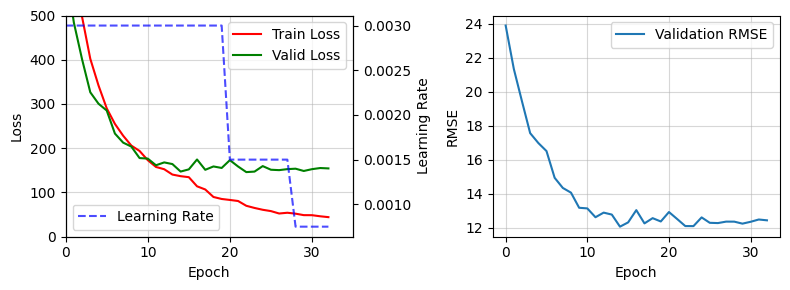

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 35)
axes[0].set_ylim(0, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [24]:
data.describe()

,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000
mean,6.649692,12.044548,26.624722,45.318097,33.274414
std,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.000000,3.200000,8.800000,25.271500,16.026100
50%,1.423500,7.980900,20.800000,40.300000,27.108200
75%,7.242900,17.637800,35.083400,57.880000,43.675700
max,71.786500,83.840700,157.983600,185.700000,157.983600


In [25]:
history_pd = pd.DataFrame(history)
history_pd.to_csv(os.path.join(model_dir, 'history_dinov2_small.csv'), index=False)

In [26]:
display(history_pd)

,train_loss,valid_loss,val_rmse,pre_target_rmse,learning_rate
0,784.634745,611.103134,23.889426,"[8.808541, 15.962036, 22.913393, 37.503963, 24...",0.00300
1,600.046913,483.849785,21.338278,"[8.439367, 15.9409485, 21.458834, 32.023426, 2...",0.00300
2,496.789368,400.930992,19.431996,"[8.275007, 16.029541, 18.715984, 28.815557, 19...",0.00300
3,402.165391,326.455101,17.565841,"[8.17903, 15.7066, 16.88666, 25.591848, 17.002...",0.00300
4,341.966354,300.634026,16.986217,"[7.925717, 15.408196, 16.666372, 23.619553, 17...",0.00300
5,290.261644,285.278498,16.512223,"[7.3083477, 16.076788, 15.114363, 24.406393, 1...",0.00300
6,254.995991,233.130754,14.940236,"[7.100452, 15.67502, 13.19468, 21.67646, 13.26...",0.00300
7,228.364057,212.686800,14.345621,"[6.814623, 15.642984, 12.182052, 20.978456, 12...",0.00300
8,205.943118,203.683733,14.068533,"[6.835699, 15.658114, 12.012971, 19.97845, 12....",0.00300
9,193.869321,177.767147,13.179698,"[6.7667475, 15.366107, 10.378015, 19.12778, 10...",0.00300


In [27]:
best_model = torch.load(os.path.join(model_dir, 'best_model_dinov2_small.pth'))
model.load_state_dict(best_model)
model.eval()

test_loss, test_rmse, all_test_preds, all_test_targs  = validate_epoch(model, test_loader, criterion, device)

Validation: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


In [28]:
print(f"test loss: {test_loss:.1f}")
print(f"test rmse: {test_rmse:.1f}")
print(f"test per target rmse: {np.sqrt(np.mean((all_test_preds - all_test_targs)**2, axis=0))}")


test loss: 129.0
test rmse: 11.4
test per target rmse: [ 8.110138  9.237161 10.444375 17.248077  9.351015]


In [29]:
len(test_data)

12

In [31]:
for targets in target_names[:1]:
    print(test_data[targets].values)

[ 5.2     0.2727  5.3     0.     22.69    0.     22.5242  0.      2.6
  3.5026 12.9283 58.88  ]


In [33]:
all_test_preds.shape

(12, 5)

In [42]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for i , tar in enumerate(target_names):

    true_target = test_data[tar].values
    pred_target = all_test_preds[:, i]

    mse = mean_squared_error(true_target, pred_target) 
    rmse = np.sqrt(mse)
    r2 = r2_score(true_target, pred_target)
    mae = mean_absolute_error(true_target, pred_target)
    print(f"-- target: {tar}")
    print(f" mean: {np.mean(true_target):.2f}")
    print(f" rmse: {rmse:.2f}")
    print(f" r2: {r2:.2f}")
    print(f" mae: {mae:.2f}")

-- target: Dry_Clover_g
 mean: 11.16
 rmse: 8.11
 r2: 0.76
 mae: 5.70
-- target: Dry_Dead_g
 mean: 13.50
 rmse: 9.24
 r2: 0.60
 mae: 7.08
-- target: Dry_Green_g
 mean: 18.96
 rmse: 10.44
 r2: 0.68
 mae: 8.39
-- target: Dry_Total_g
 mean: 43.61
 rmse: 17.25
 r2: 0.55
 mae: 13.46
-- target: GDM_g
 mean: 30.12
 rmse: 9.35
 r2: 0.76
 mae: 7.24
